In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os

GOOD_IMAGES_PATH = '/content/gdrive/MyDrive/quality_segmentation/appropriate/img'
BAD_IMAGES_PATH = '/content/gdrive/MyDrive/quality_segmentation/bad/img'
GOOD_IMAGES_ANN = '/content/gdrive/MyDrive/quality_segmentation/appropriate/ann/'
BAD_IMAGES_ANN = '/content/gdrive/MyDrive/quality_segmentation/bad/ann/'
GOOD_IMAGES_MASKS = '/content/gdrive/MyDrive/quality_segmentation/appropriate/masks_machine/'
BAD_IMAGES_MASKS = '/content/gdrive/MyDrive/quality_segmentation/bad/masks_machine/'

good_img_filenames = os.listdir(GOOD_IMAGES_PATH)
bad_img_filenames = os.listdir(BAD_IMAGES_PATH)

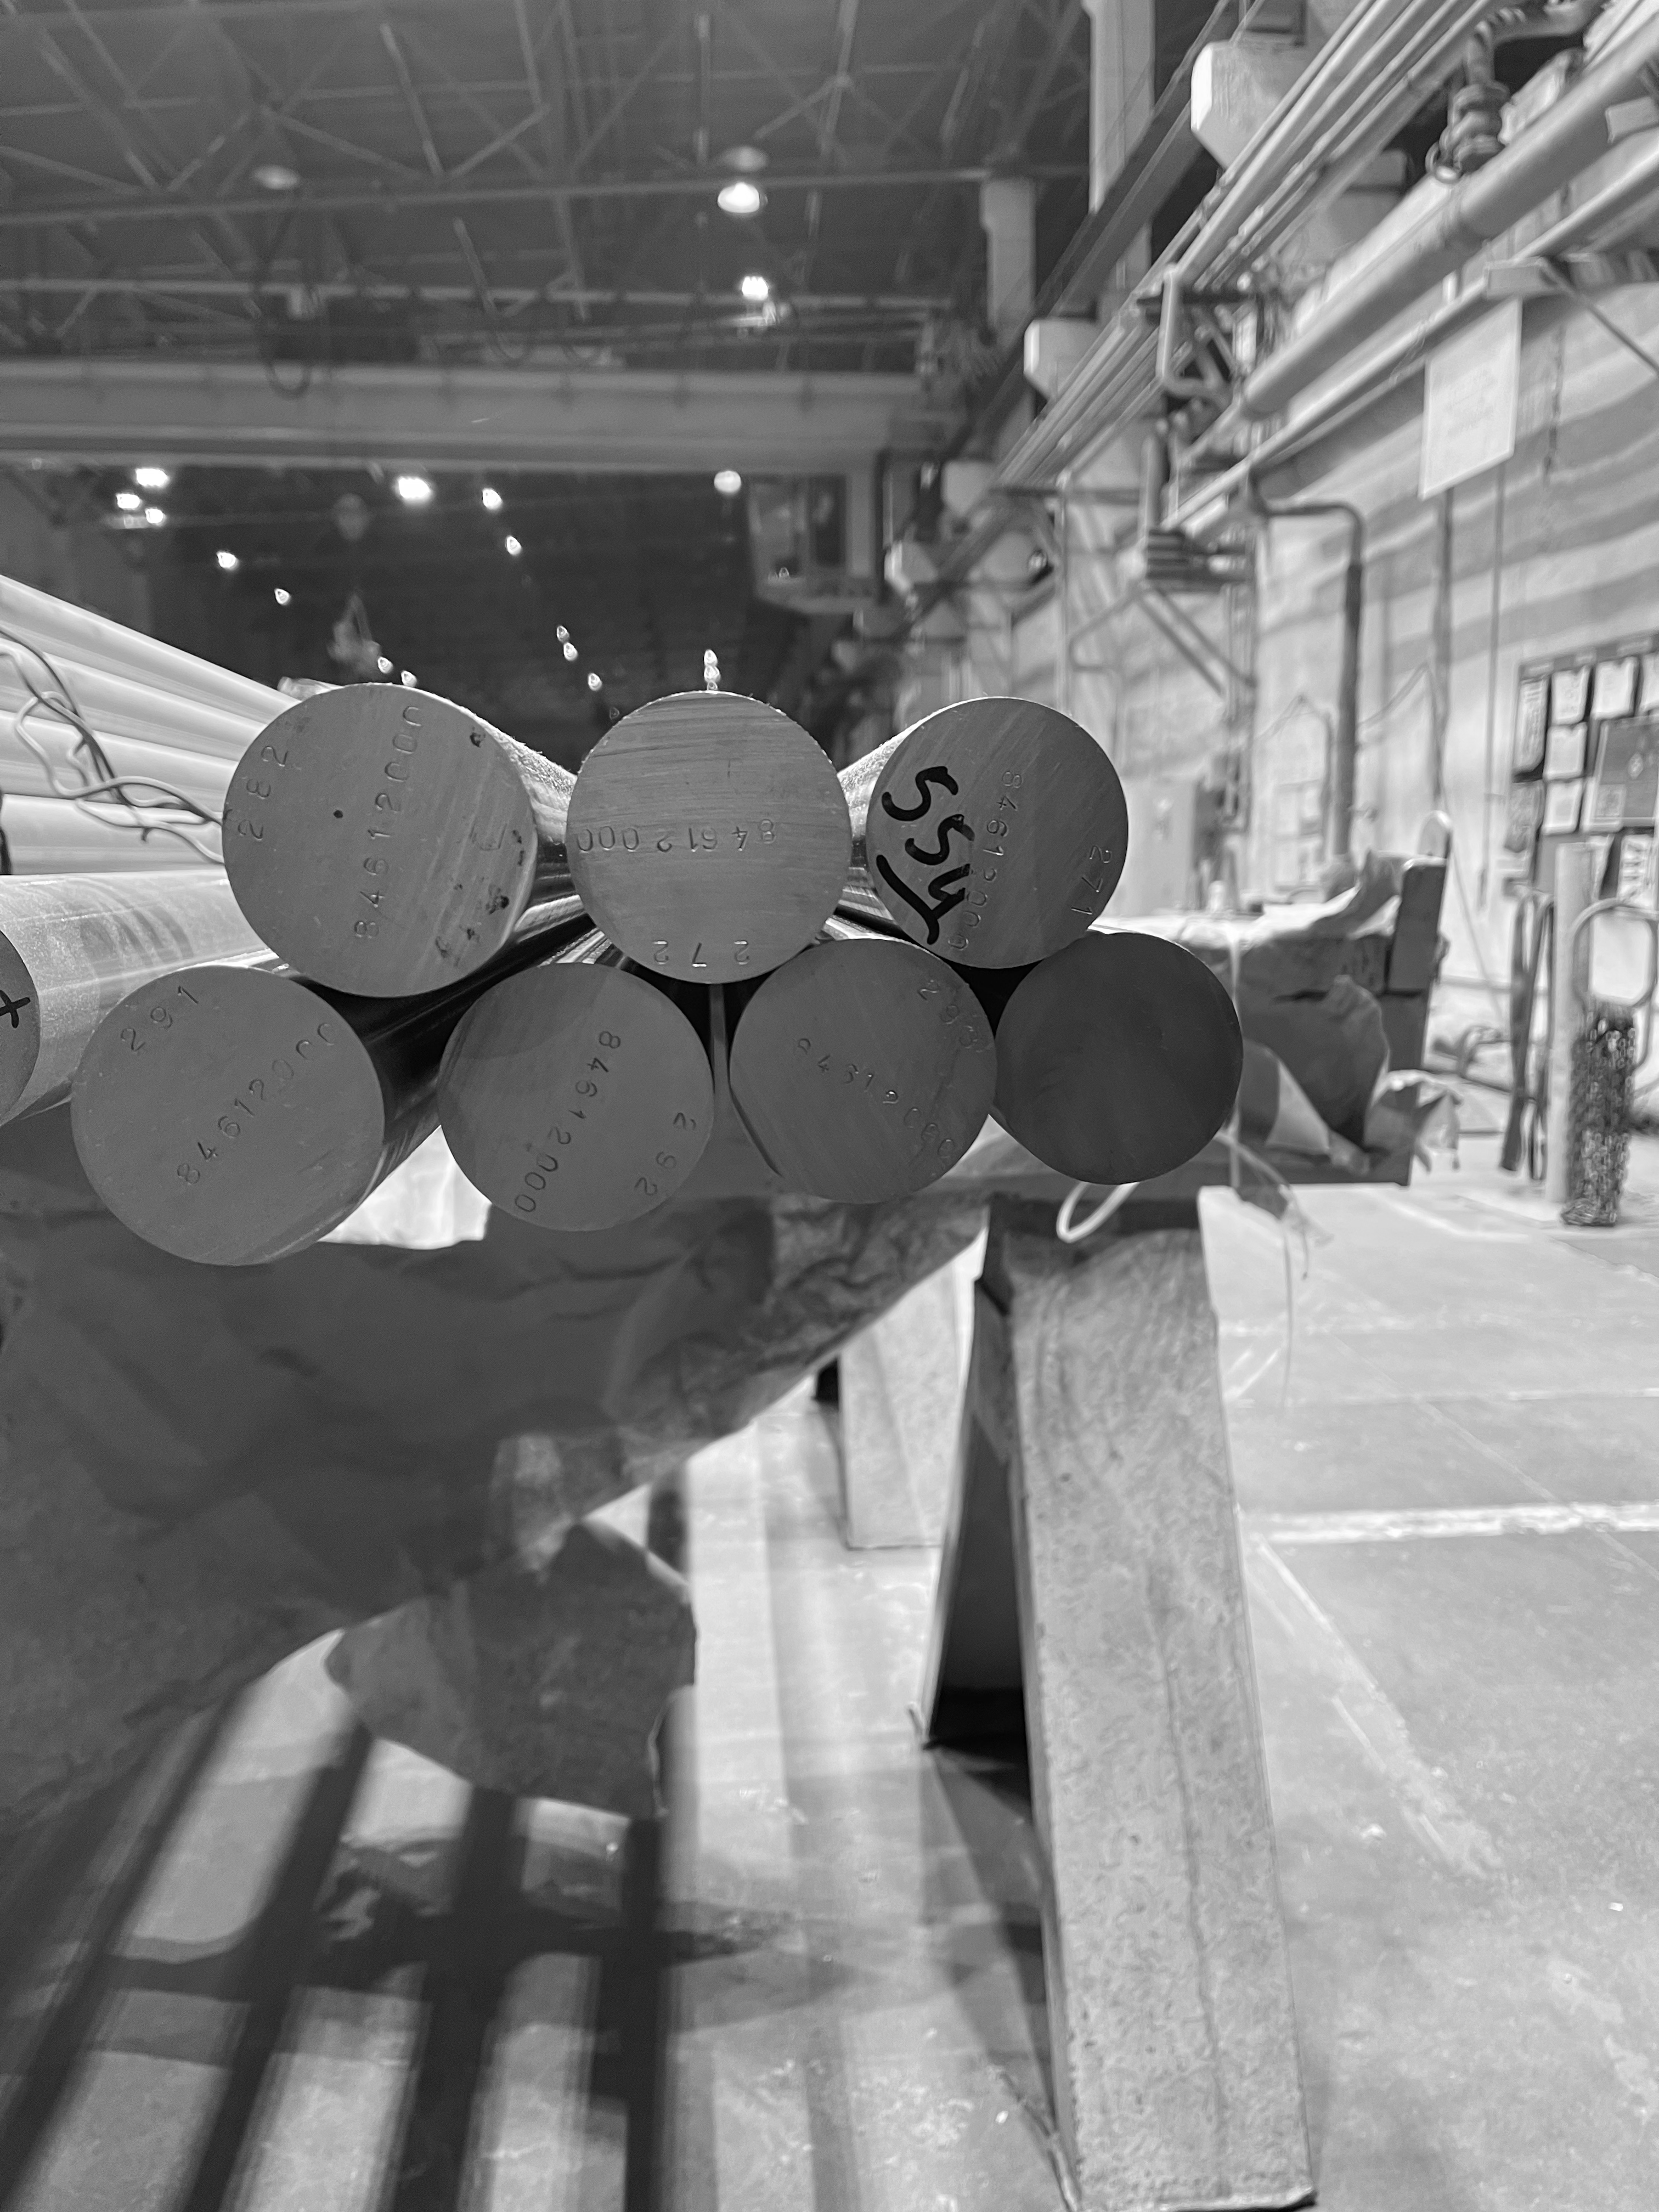

In [ ]:
img_example = GOOD_IMAGES_PATH + '/IMG_1748.png'
image = cv2.imread(img_example)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
plt.show()

In [ ]:
from scipy.ndimage import convolve
import numpy as np

def BREN(image):
  intensity = image / 255
  kernel = np.array([[1, 0, -1]])
  return np.mean(convolve(intensity, kernel)[:-1, :-1] ** 2)

In [ ]:
data_dict = dict()
filename_to_index = dict()

for i, name in enumerate(good_img_filenames + bad_img_filenames):
  filename_to_index[name] = i
data_dict['img_file'] = list(filename_to_index.keys())
data_dict['is_good'] = [1] * len(good_img_filenames) + [0] * len(bad_img_filenames)

brens = [0] * len(filename_to_index.keys())
for img in os.listdir(GOOD_IMAGES_PATH):
  curr_image = GOOD_IMAGES_PATH + '/' + img
  image = cv2.imread(curr_image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  brens[filename_to_index[img]] = BREN(gray)
for img in os.listdir(BAD_IMAGES_PATH):
  curr_image = BAD_IMAGES_PATH + '/' + img
  image = cv2.imread(curr_image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  brens[filename_to_index[img]] = BREN(gray)
data_dict['BREN'] = brens

In [ ]:
def CONT(image):
  intensity = image / 255
  kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
  return np.mean(convolve(intensity, kernel)[:-1, :-1])

conts = [0] * len(filename_to_index.keys())
for img in os.listdir(GOOD_IMAGES_PATH):
  curr_image = GOOD_IMAGES_PATH + '/' + img
  image = cv2.imread(curr_image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  conts[filename_to_index[img]] = CONT(gray)
for img in os.listdir(BAD_IMAGES_PATH):
  curr_image = BAD_IMAGES_PATH + '/' + img
  image = cv2.imread(curr_image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  conts[filename_to_index[img]] = CONT(gray)
data_dict['CONT'] = conts

In [ ]:
import json

def get_rods_count(json_file, good=True):
  path = GOOD_IMAGES_ANN if good else BAD_IMAGES_ANN
  with open(path + json_file) as f:
    file_content = f.read()
    annotation = json.loads(file_content)
  return len(annotation['objects'])

In [ ]:
rods_counts = [0] * len(filename_to_index.keys())

for name in filename_to_index.keys():
  json_filename = name + '.json'
  flag = (data_dict['is_good'][filename_to_index[name]] == 1)
  rods_counts[filename_to_index[name]] = get_rods_count(json_filename, good=flag)
data_dict['rods_count'] = rods_counts

In [ ]:
def get_rods_area(mask_file, good=True):
  path = GOOD_IMAGES_MASKS if good else BAD_IMAGES_MASKS
  image = cv2.imread(path + mask_file)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rods_pixels = np.sum(np.where(gray > 0, 1, 0))
  return rods_pixels / (gray.shape[0] * gray.shape[1])

In [ ]:
rods_areas = [0] * len(filename_to_index.keys())

for name in filename_to_index.keys():
  mask_filename = name.replace('jpg', 'png')
  flag = (data_dict['is_good'][filename_to_index[name]] == 1)
  rods_areas[filename_to_index[name]] = get_rods_area(mask_filename, good=flag)
data_dict['rods_area'] = rods_areas

In [ ]:
def GRA6(gray_image_path, kernel_size=3):
  image = cv2.imread(gray_image_path)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  laplacian = cv2.Laplacian(gray_image,cv2.CV_64F)
  return np.mean(convolve(laplacian, np.ones((kernel_size, kernel_size))[:-1, :-1]))

In [ ]:
gra6_scores = [0] * len(filename_to_index.keys())

for name in filename_to_index.keys():
  flag = (data_dict['is_good'][filename_to_index[name]] == 1)
  path = (GOOD_IMAGES_PATH if flag else BAD_IMAGES_PATH) + '/' + name
  gra6_scores[filename_to_index[name]] = GRA6(path)
data_dict['GRA6'] = rods_areas

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(data_dict)

img_file  is_good      BREN      CONT  rods_count  rods_area      GRA6
0   IMG_1748.png        1  0.000734  0.487279           8   0.118923  0.118923
1   IMG_1751.png        1  0.000595  0.471573           4   0.321854  0.321854
2   IMG_1749.png        1  0.000728  0.484711           7   0.118760  0.118760
3   IMG_1752.png        1  0.000652  0.482730           8   0.167471  0.167471
4   IMG_1750.png        1  0.000613  0.456690           6   0.431912  0.431912
..           ...      ...       ...       ...         ...        ...       ...
66  IMG_6422.jpg        0  0.000701  0.503653          15   0.109752  0.109752
67  IMG_6420.jpg        0  0.000599  0.472583          30   0.202455  0.202455
68  IMG_6425.jpg        0  0.000637  0.538298           3   0.625974  0.625974
69  IMG_6421.jpg        0  0.000526  0.460379           6   0.595856  0.595856
70  IMG_6426.jpg        0  0.000454  0.547209           3   0.346976  0.346976

[71 rows x 7 columns]